In [1]:
# Import preliminaries

import requests
import pandas as pd
import config
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base = 'https://api.stlouisfed.org/fred/series/observations?series_id='

s_list = {
    'Manufacturing': 'CES3000000008',
    'Mining and Logging': 'CES1000000008',
    'Information': 'CES5000000008',
    'Financial Activities': 'CES5500000008',
    'Professional and Business Services': 'CES6000000008',
    'Education and Health Services': 'CES6500000008',
    'Leisure and Hospitality': 'CES7000000008',
    'Other Services': 'CES8000000008',
    'Trade, Transportation, and Utilities': 'CES4000000008',
    'Total Private': 'AHETPI',
    'CPI All Urban Consumers': 'CPIAUCSL',
    'CPI-Urban Wage Earners and Clerical Workers': 'CWUR0000SA0'
}

dates = '&observation_start=1964-01-01'
key = '&api_key={}'.format(config.fred_key)
ftype = '&file_type=json'

d = {}
p_list = ['CPIAUCSL', 'CWUR0000SA0']
w_list = {k:v for k,v in s_list.iteritems() if v not in p_list}
for k, v in s_list.iteritems():
    url = '{}{}{}{}{}'.format(base, v, dates, key, ftype)
    df = pd.DataFrame(requests.get(url).json()['observations'])
    df = df.set_index(pd.to_datetime(df['date']))
    df = df.rename(columns={'value': v})[v].astype(float)
    d[v] = df
df = pd.DataFrame(d)
for k, v in w_list.iteritems():
    df[v+'_rw'] = df[v].multiply(df['CWUR0000SA0'][0]).divide(
        df['CWUR0000SA0']).pct_change(12).multiply(100)

In [11]:
df[420:]['CES1000000008']

date
1999-01-01    16.37
1999-02-01    16.30
1999-03-01    16.31
1999-04-01    16.26
1999-05-01    16.31
1999-06-01    16.31
1999-07-01    16.44
1999-08-01    16.36
1999-09-01    16.39
1999-10-01    16.37
1999-11-01    16.30
1999-12-01    16.28
2000-01-01    16.37
2000-02-01    16.38
2000-03-01    16.42
2000-04-01    16.55
2000-05-01    16.58
2000-06-01    16.58
2000-07-01    16.57
2000-08-01    16.58
2000-09-01    16.58
2000-10-01    16.62
2000-11-01    16.64
2000-12-01    16.74
2001-01-01    16.76
2001-02-01    16.83
2001-03-01    16.85
2001-04-01    16.78
2001-05-01    16.91
2001-06-01    17.12
              ...  
2014-11-01    26.97
2014-12-01    26.67
2015-01-01    26.53
2015-02-01    26.49
2015-03-01    26.49
2015-04-01    26.30
2015-05-01    26.37
2015-06-01    26.28
2015-07-01    26.40
2015-08-01    26.54
2015-09-01    26.79
2015-10-01    26.65
2015-11-01    26.63
2015-12-01    26.59
2016-01-01    26.84
2016-02-01    26.86
2016-03-01    26.90
2016-04-01    27.13
2016-05-01    2

In [21]:
w_list = {k:v for k,v in s_list.iteritems() if v not in p_list}
for k, v in w_list.iteritems():
    w_list[k] = {'series': v}
    w_list[k]['current_month'] = df.index[-1].strftime('%b %Y')
    w_list[k]['nominal_wage'] = str(df[v][-1])
    w_list[k]['wage_growth_curr'] = str(df[v+'_rw'][-1].round(3))
    ch_val = df.ix['2000-01-01'][v+'_rw']
    w_list[k]['cumulative_change'] = str(round((df[v][-1] - ch_val)/ch_val,2))
w_list

{'Education and Health Services': {'cumulative_change': '41.37',
  'current_month': 'Apr 2017',
  'nominal_wage': '22.95',
  'series': 'CES6500000008',
  'wage_growth_curr': '-0.003'},
 'Financial Activities': {'cumulative_change': '427.54',
  'current_month': 'Apr 2017',
  'nominal_wage': '26.49',
  'series': 'CES5500000008',
  'wage_growth_curr': '-0.67'},
 'Information': {'cumulative_change': '172.04',
  'current_month': 'Apr 2017',
  'nominal_wage': '30.54',
  'series': 'CES5000000008',
  'wage_growth_curr': '0.202'},
 'Leisure and Hospitality': {'cumulative_change': '15.07',
  'current_month': 'Apr 2017',
  'nominal_wage': '13.3',
  'series': 'CES7000000008',
  'wage_growth_curr': '1.889'},
 'Manufacturing': {'cumulative_change': '18.09',
  'current_month': 'Apr 2017',
  'nominal_wage': '20.72',
  'series': 'CES3000000008',
  'wage_growth_curr': '-0.51'},
 'Mining and Logging': {'cumulative_change': '-11.02',
  'current_month': 'Apr 2017',
  'nominal_wage': '27.83',
  'series': 'C

In [22]:
w_list = OrderedDict(sorted(w_list.iteritems(), key=lambda x: float(x[1]['cumulative_change'])))

bar_vals = [float(w_list[k]['cumulative_change']) for k in w_list.keys()]

pd.DataFrame(w_list).T['cumulative_change'].astype(float).sort_values(ascending=False).reset_index().to_json('ahe.json', orient='records')

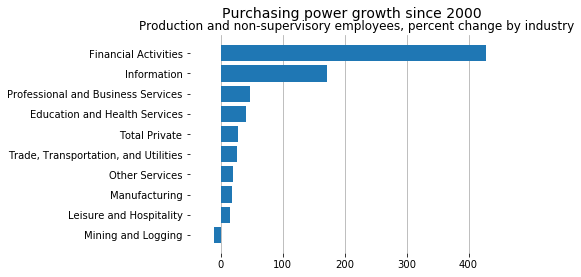

In [23]:
fig, ax = plt.subplots()
ax.xaxis.grid(True)
plt.barh(range(len(w_list)), bar_vals, align='center', zorder=3)
plt.yticks(range(len(w_list)), w_list.keys())
plt.title('Production and non-supervisory employees, percent change by industry')
plt.suptitle('Purchasing power growth since 2000', fontsize=14)
plt.subplots_adjust(top=0.88)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlim(-50, 490)

plt.show()

# Need to add footnote with source
# Need to sort 
# Need to make to
# Value labels

In [24]:
#df['CES3000000008_rw'].plot()